In [160]:
import pandas as pd
import numpy as np
import joblib
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupKFold 
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer

# Load dataset
df1 = pd.read_csv('/Users/emme/Desktop/ca1-dataset.csv')
df2 = pd.read_csv('/Users/emme/Desktop/ca2-dataset.csv')

# Map 'Behaviour' in df2 to 'OffTask' in df1
mapping = {'Y': 'OFF TASK', 'N': 'ON TASK'}
df2['Behaviour'] = df2['Behaviour'].map(mapping)

# Merge df1 and df2 based on the 'namea' column
merged_df = df1.merge(df2, on='namea', how='inner')
print("Columns in merged_df:", merged_df.columns)

# Calculate the time since the last help request
merged_df['TimeSinceLastHelp'] = merged_df.groupby('namea')['time'].diff()

# Calculate the time since the last wrong attempt
merged_df['TimeSinceLastWrong'] = merged_df.groupby('namea')['time'].diff().where(merged_df['notright'] == 1, 0)

# Calculate the count of actions in the last 5 actions
merged_df['Last5ActionsCount'] = merged_df.groupby('namea')['time'].rolling(window=5, min_periods=0).count().reset_index(0, drop=True)

# Calculate the count of actions within the same sequence
merged_df['ActionSequenceCount'] = merged_df.groupby('namea').cumcount() + 1

# Calculate the average time per action
merged_df['AvgTimePerAction'] = merged_df.groupby('namea')['time'].transform('mean')
# Calculate the time since last help request ratio
merged_df['TimeSinceLastHelpRatio'] = merged_df['TimeSinceLastHelp'] / merged_df['AvgTimePerAction']

# Calculate the time since last wrong attempt ratio
merged_df['TimeSinceLastWrongRatio'] = merged_df['TimeSinceLastWrong'] / merged_df['AvgTimePerAction']

# Calculate the cumulative count of help requests
merged_df['CumulativeHelpRequests'] = merged_df.groupby('namea')['howmanywrong-up'].cumsum()

# Calculate the cumulative count of wrong attempts (excluding help)
merged_df['CumulativeWrongAttempts'] = (merged_df['howmanywrong-up'] - merged_df['recent8help']).groupby(merged_df['namea']).cumsum()

# Calculate the recent help requests ratio
merged_df['RecentHelpRequestsRatio'] = merged_df['recent8help'] / merged_df.groupby('namea')['recent8help'].transform('sum')

# Calculate the recent help requests ratio (keeping it since 'recent8help' is available)
merged_df['RecentHelpRequestsRatio'] = merged_df['recent8help'] / merged_df.groupby('namea')['recent8help'].transform('sum')
# Calculate the change in knowledge estimate
merged_df['KnowledgeChange'] = merged_df['Pknow-2'] - merged_df['pknow-1']

# Calculate the cumulative change in knowledge estimate
merged_df['CumulativeKnowledgeChange'] = merged_df.groupby('namea')['KnowledgeChange'].cumsum()

# Calculate the average time gap between consecutive actions
merged_df['AvgTimeGapBetweenActions'] = merged_df.groupby('namea')['time'].diff().fillna(0).mean()

# Calculate the cumulative count of help requests
merged_df['CumulativeHelpRequests'] = merged_df.groupby('namea')['howmanywrong-up'].cumsum()

# group by namea
group_dict = {}
groups = np.array([])

for index, row in merged_df.iterrows():
    name = row['namea']
    if name not in group_dict:
        group_dict[name] = index
    groups = np.append(groups, group_dict[name])
     
# Drop rows with 'ON TASK CONV', '$', and '?' under the 'Behaviour' column
merged_df = merged_df[~merged_df['Behaviour'].isin(['ON TASK CONV', '$', '?'])]

# set up X abd y to predict 'OffTask' 
X = merged_df.drop(columns=['OffTask']+['namea']+['Unique-id_x']+ ['Unique-id_y']+['lesson']+['prod']+['cell']+['Coder'], axis=1)  
y = merged_df['OffTask'] 
y = y.map({'N': 0, 'Y': 1})

# Initialize a list to store kappa scores for each fold
kappa_scores = list()

Columns in merged_df: Index(['Unique-id_x', 'namea', 'OffTask', 'Avgright', 'Avgbug', 'Avghelp',
       'Avgchoice', 'Avgstring', 'Avgnumber', 'Avgpoint', 'Avgpchange',
       'Avgtime', 'AvgtimeSDnormed', 'Avgtimelast3SDnormed',
       'Avgtimelast5SDnormed', 'Avgnotright', 'Avghowmanywrong-up',
       'Avghelppct-up', 'Avgwrongpct-up', 'Avgtimeperact-up',
       'AvgPrev3Count-up', 'AvgPrev5Count-up', 'Avgrecent8help',
       'Avg recent5wrong', 'Avgmanywrong-up', 'AvgasymptoteA-up',
       'AvgasymptoteB-up', 'Row', 'lesson', 'prod', 'cell', 'right', 'bug',
       'help', 'choice', 'string', 'number', 'point', 'pknow-1', 'Pknow-2',
       'pchange', 'time', 'timeSDnormed', 'timelast3SDnormed',
       'timelast5SDnormed', 'notright', 'howmanywrong-up', 'helppct-up',
       'wrongpct-up', 'timeperact-up', 'Prev3Count-up', 'Prev5Count-up',
       'recent8help', ' recent5wrong', 'manywrong-up', 'asymptoteA-up',
       'asymptoteB-up', 'Behaviour', 'Coder', 'Unique-id_y'],
      dtype='o

In [161]:
# Handle missing values in X using SimpleImputer (you can adjust the strategy as needed)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Initialize a list to store kappa scores for each fold
kappa_scores = []

# Perform 10-fold student-level batch cross-validation
gkf = GroupKFold(n_splits=10)
for train_index, test_index in gkf.split(X_selected, y, groups=groups):
    X_train = X_selected[train_index]
    X_test = X_selected[test_index]
    y_train = y[train_index]
    y_test = y[test_index]  
    
# Perform feature selection using SelectKBest
k = 10
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
    
# Create and fit the classifier to training data
model = XGBClassifier()
model.fit(X_train_selected, y_train)

# Make predictions on test data
y_pred = model.predict(X_test_selected)

# Calculate kappa score and append to the list
kappa = cohen_kappa_score(y_test, y_pred)
kappa_scores.append(kappa)

# Calculate the mean kappa score across all folds
mean_kappa = np.mean(kappa_scores)
print("Mean Kappa Score:", mean_kappa)

Mean Kappa Score: 0.66161838513692


In [162]:
# Calculate other scores
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the computed metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.97
Recall: 0.51
F1-Score: 0.68
ROC AUC: 0.76


In [163]:
## Save the trained model to a file using joblib
model_filename = 'trained_model.joblib'
joblib.dump(model, model_filename)

print(f"Model saved as '{model_filename}'")

Model saved as 'trained_model.joblib'


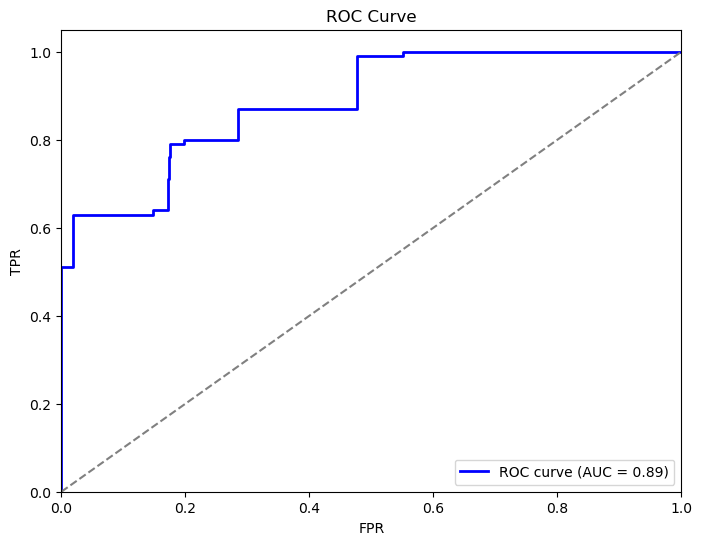

In [164]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Predict the probabilities of the positive class (class 1)
y_pred = model.predict_proba(X_test_selected)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC 
roc_auc = roc_auc_score(y_test, y_pred)

## Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()